# Comparing by critical lifetime ratio (PHASOR part)
Simulating the lifetime decay from 3.07 to 2.5, for 20 points. Amplitude the same as before. Derive the index of separability to obtain critical
lifetime ratio.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import fsolve
from TCSPC import *

plt.style.use('seaborn-v0_8-deep')

In [92]:
# define functions from phasor.ipynb
def phasor_eq_func_A_vary(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1,A2, tau1, tau2)
       Input: 
       A_tau_arr    parameter array A1,A2 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int(len(A_tau_arr)/2) #number of components
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) #pure multiexponential
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    A_sum = 1-np.sum(A_tau_arr[:n]) #A1,...An sum to 1
    phasor_compare = phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    return [A_sum]+list(phasor_compare) #

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    return phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    

def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)

In [93]:
# simulation for different lifetimes
tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.5,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])

In [59]:
# calculate means and standard deviations
mean = np.mean(par_arr,axis = 1)
std = np.std(par_arr,axis = 1)

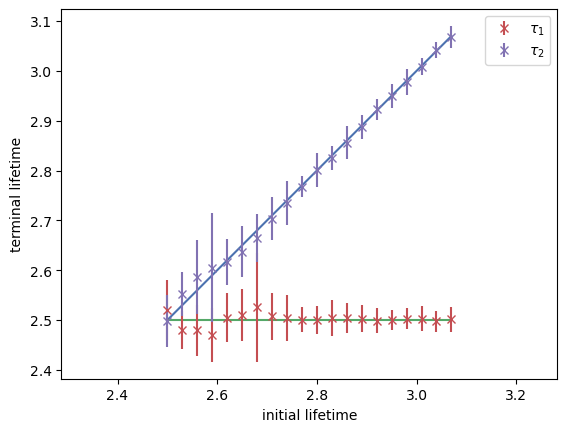

In [5]:
# plot 1D graph for simulated data
plt.figure()
plt.axis("equal")
plt.plot(tau_array,tau_array)
plt.plot([2.5,3.07],[2.5,2.5])
plt.errorbar(tau_array,mean[:,1],yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,mean[:,2],yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.xlabel("initial lifetime")
plt.ylabel("terminal lifetime")
plt.legend()
plt.show()

## Simulation for lifetimes

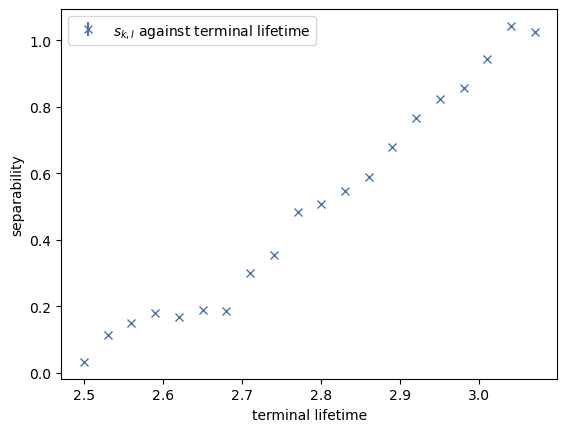

In [6]:
# calculate separability and plot it against terminal lifetime
separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5

plt.figure()
plt.errorbar(tau_array,separability_kl,yerr=0,fmt = 'x',label="$s_{k,l}$ against terminal lifetime")

plt.xlabel("terminal lifetime")
plt.ylabel("separability")
plt.legend()
plt.show()

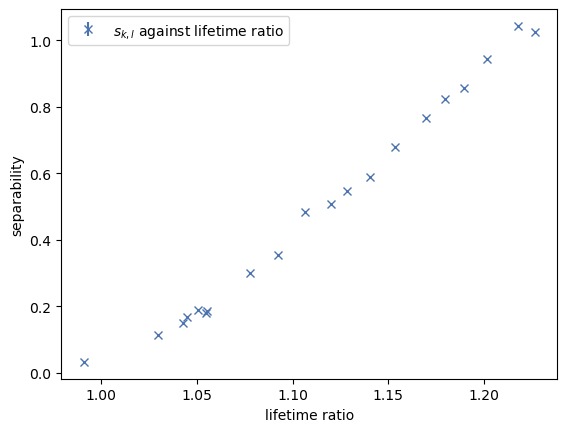

In [7]:
# plot separability against lifetime ratio
plt.figure()
plt.errorbar(mean[:,2]/mean[:,1],separability_kl,yerr=0,fmt = 'x',label="$s_{k,l}$ against lifetime ratio")

plt.xlabel("lifetime ratio")
plt.ylabel("separability")
plt.legend()
plt.show()

In [8]:
# give the separabilitis and the critical lifetime where the lifetimes start to be separable
s_min = 0
for i in range(20):
    if separability_kl[i] < 1: 
        print("separability_kl is ", separability_kl[i], ", it's first nonseparatable pair of liftimes.")
    else:
        s_min = i
        print("separability_kl is ", separability_kl[i])
        print(f"The lifetimes are separable from the {i+1}th data. ")
        print(f"Thus, the critical lifetime ratio is {mean[i,2]/mean[i,1]}")
        break        

separability_kl is  0.033183682816974855 , it's first nonseparatable pair of liftimes.
separability_kl is  0.11422518709989653 , it's first nonseparatable pair of liftimes.
separability_kl is  0.15056149270762115 , it's first nonseparatable pair of liftimes.
separability_kl is  0.1796966353165085 , it's first nonseparatable pair of liftimes.
separability_kl is  0.1697480451551527 , it's first nonseparatable pair of liftimes.
separability_kl is  0.1881495600797101 , it's first nonseparatable pair of liftimes.
separability_kl is  0.1873857591959697 , it's first nonseparatable pair of liftimes.
separability_kl is  0.29940848772283574 , it's first nonseparatable pair of liftimes.
separability_kl is  0.35490355399109236 , it's first nonseparatable pair of liftimes.
separability_kl is  0.48518702086676285 , it's first nonseparatable pair of liftimes.
separability_kl is  0.5072483462879966 , it's first nonseparatable pair of liftimes.
separability_kl is  0.5458811025743909 , it's first nonsep

## Simulation for number of photons

In [9]:
# generate data with different number of photons by EGFP
n_photon_arr = np.logspace(4,9,20).astype(int)
result_array = np.zeros((20,20,10,3))
for i in range(20):
    EGFP.n_photon = n_photon_arr[i]
    for j in range(20): 
        EGFP.tau = [2.5,tau_array[j]]
        for k in range(10): #no background
            EGFP.repeat_sim(10)
            phasor = EGFP.phasor_data[k]
            result_array[i,j,k] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])        

C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\478917416.py:23: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AAA\TCSPC.py:168: RuntimeWarning: invalid value encountered in divide
  phasor = (np.fft.fft(y).T/y_sum).T/np.fft.fft(ker)*np.sum(ker)
C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\478917416.py:22: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential


In [10]:
# calculate para
mean_new = np.mean(result_array,axis = 2)
std_new = np.std(result_array,axis = 2)

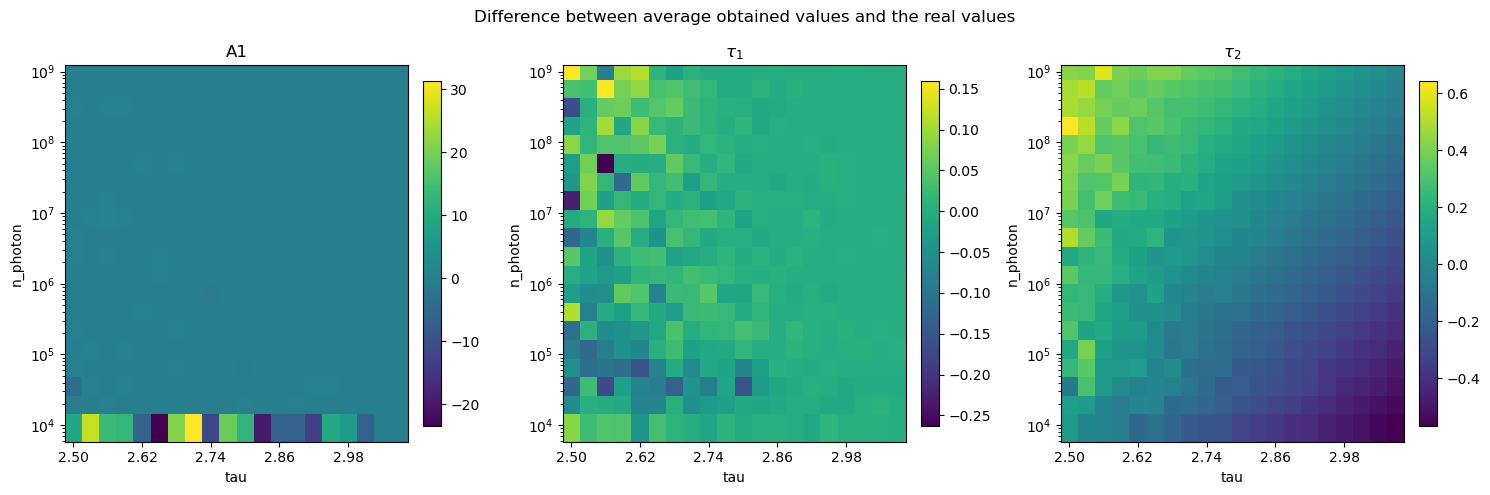

In [11]:
# plot 2D graphs
N,T2 = np.meshgrid(n_photon_arr,tau_array)
N,T1 = np.meshgrid(n_photon_arr,np.ones(20)*2.5)
N,A1 = np.meshgrid(n_photon_arr,np.ones(20)*0.497)
true = [A1,T1,T2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Difference between average obtained values and the real values')
for i in range(3):
    cax = axs[i].pcolormesh(T2,N,mean_new[:,:,i]-true[i])
    axs[i].set_title('First Image')
    fig.colorbar(cax, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_yscale('log')
    axs[i].set_aspect('auto')
    axs[i].set_xticks(tau_array[::4])
    axs[i].set_xlabel(f'tau')
    axs[i].set_ylabel(f'n_photon')
    axs[i].set_title(['A1',r'$\tau_1$',r'$\tau_2$'][i])

plt.tight_layout()

In [12]:
# save the figures to pdf
fig.savefig('fig/tau2_n_photon_phasor.pdf')

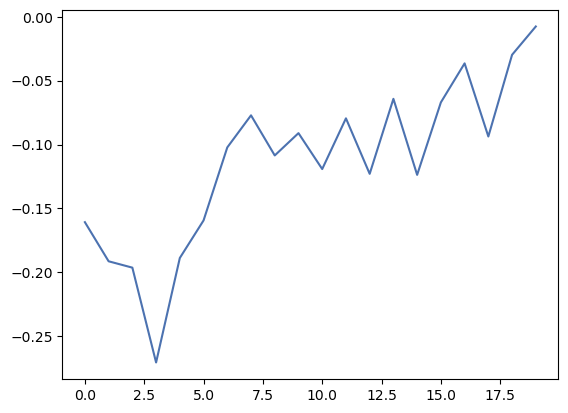

In [13]:
# show the critical points by 1D figure
plt.plot(mean_new[4,:,1]-T2[4,:])

## Comparing performance with different angular frequency

In [14]:
# discuss the behavior of phasor_solve_num for different angular frequency
def phasor_eq_func_w(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved
       x            the initial angular frequency'''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_compare = phasor_test.real[INDEX_i:2*n-1+INDEX_i]-phasor.real[INDEX_i:2*n-1+INDEX_i] #solve for A_tau_arr such that it gives 0
    return phasor_compare

def phasor_solve_num_w(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func_w,x0=x0,args=phasor)

def plot_w(x):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x: par_arr
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5

    # give the separabilitis and the critical lifetime where the lifetimes start to be separable
    s_min = 0
    critical_tau_ratio = 0
    for i in range(20):
        if separability_kl[i] < 1: 
            pass      
        else:
            s_min = i
            critical_tau_ratio = mean[i,2]/mean[i,1]
            print("separability_kl is ", separability_kl[i], ", it's first nonseparatable pair of liftimes.")
            print(f"The lifetimes are separable from the {i+1}th data. ")
            print(f"Thus, the critical lifetime ratio is {critical_tau_ratio}")
            break        

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"for angular frequency from {INDEX_i}", fontsize=16)
    axs[0].set_ylim(0,10)
    axs[1].set_ylim(0,2)
    axs[1].set_xlim(1,2)

    axs[0].plot(tau_array, tau_array)
    axs[0].plot([2.5, 3.07], [2.5, 2.5])
    axs[0].errorbar(tau_array, mean[:,1], yerr=std[:,1], fmt='x', label=rf'$\tau_{{1}}$')
    axs[0].errorbar(tau_array, mean[:,2], yerr=std[:,2], fmt='x', label=rf'$\tau_{{2}}$')
    axs[0].set_xlabel("initial lifetime")
    axs[0].set_ylabel("terminal lifetime")
    axs[0].legend()
    
    axs[1].errorbar(mean[:,2] / mean[:,1], separability_kl, yerr=0, fmt='x', label="$s_{k,l}$ against lifetime ratio")
    axs[1].set_xlabel("lifetime ratio")
    axs[1].set_ylabel("separability")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    return INDEX_i, separability_kl[s_min], critical_tau_ratio

In [15]:
INDEX_arr = np.zeros(20)
separation_arr = np.zeros(20)
critical_tau_arr = np.zeros(20)

C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


separability_kl is  1.0271543936522698 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 19th data. 
Thus, the critical lifetime ratio is 1.215118057289242


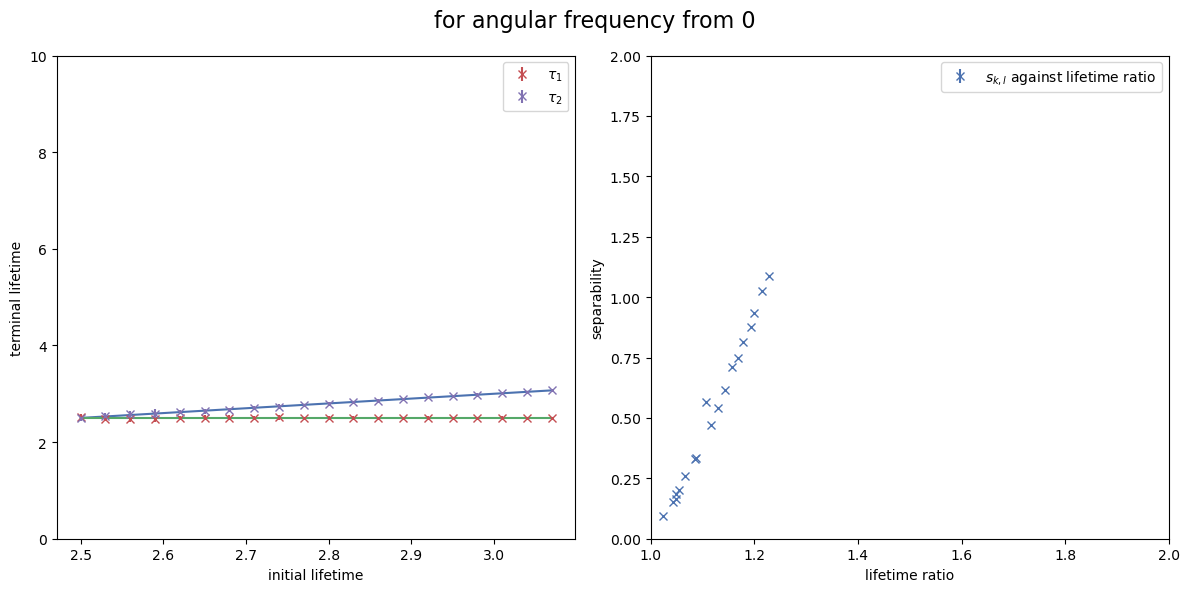

C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\228629013.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\228629013.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AAA\TCSPC.py:168: RuntimeWarning: invalid value encountered in divide
  phasor = (np.fft.fft(y).T/y_sum).T/np.fft.fft(ker)*np.sum(ker)
C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\228629013.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\228629013.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential


separability_kl is  1.2391959567062574 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 20th data. 
Thus, the critical lifetime ratio is 2.0369119470265353


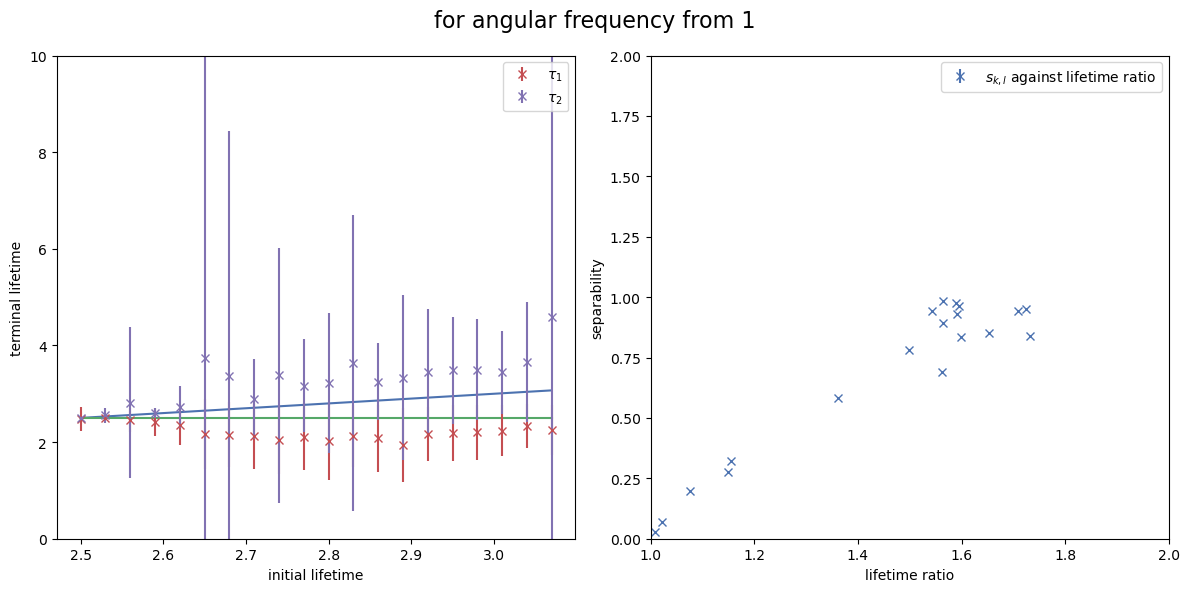

C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


separability_kl is  1.0725888911167956 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 10th data. 
Thus, the critical lifetime ratio is 1.862229331116851


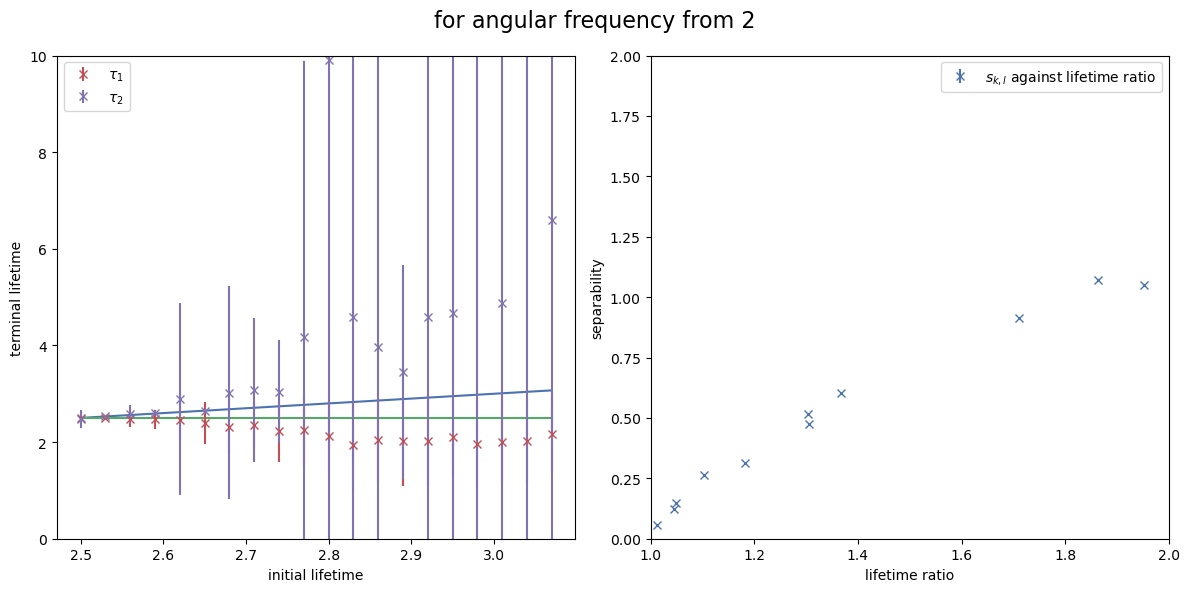

separability_kl is  2.306245914483191e+39 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 17th data. 
Thus, the critical lifetime ratio is 2.7232620148629245e+52


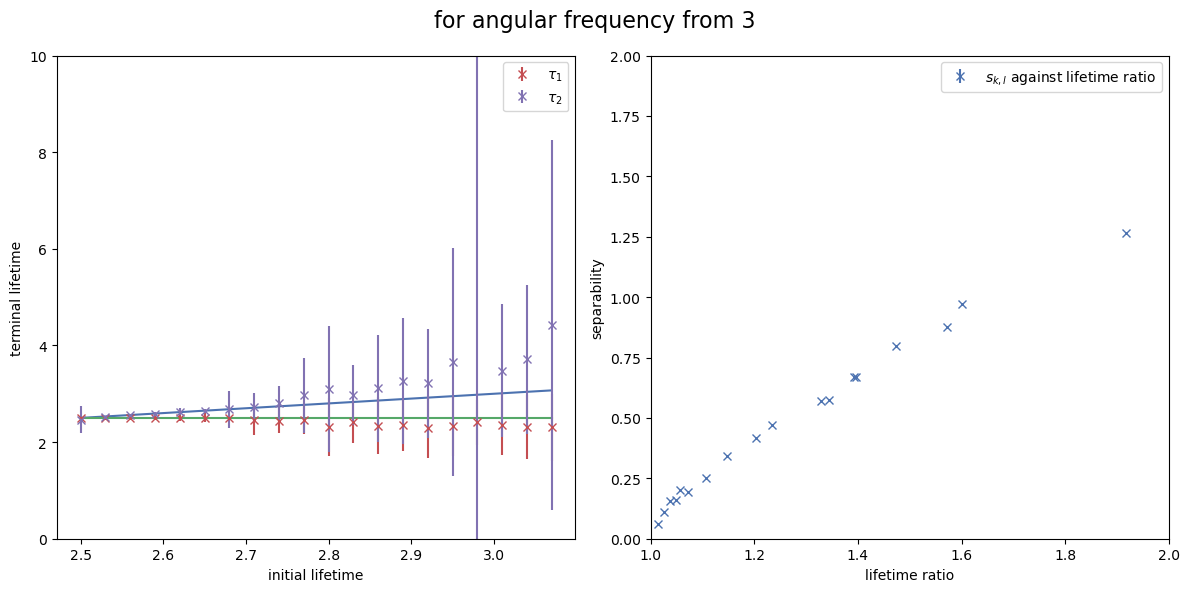

separability_kl is  1.093253873752676 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 18th data. 
Thus, the critical lifetime ratio is 1.672771497502164


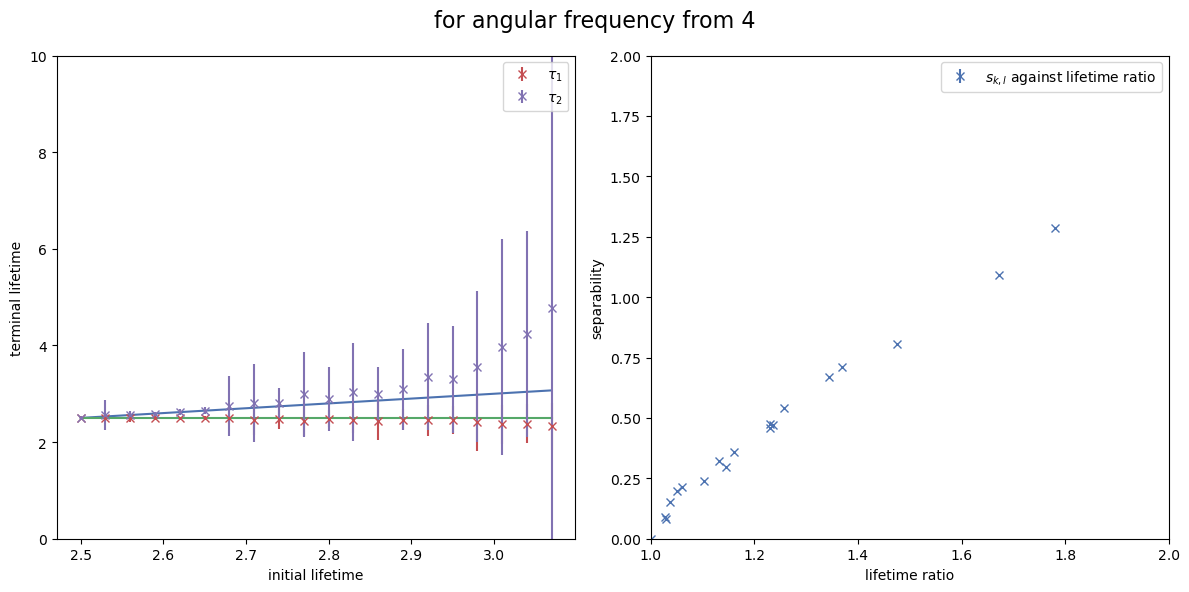

separability_kl is  1.0545875235447084 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 17th data. 
Thus, the critical lifetime ratio is 1.6768304107738026


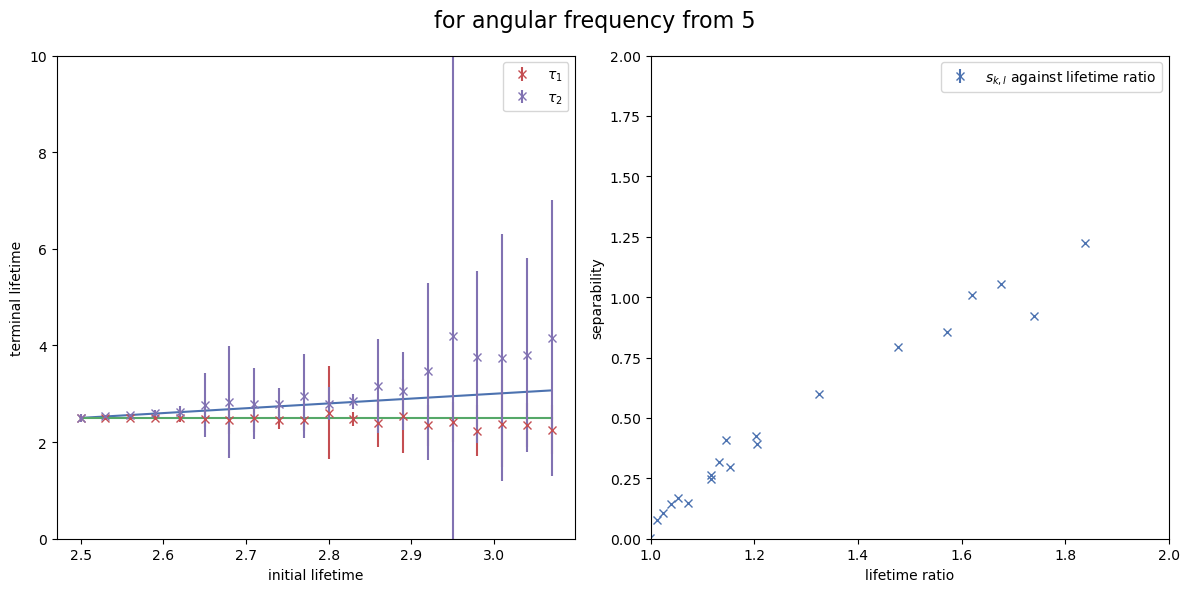

separability_kl is  1.0018171430388503 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 20th data. 
Thus, the critical lifetime ratio is 1.6207143238391237


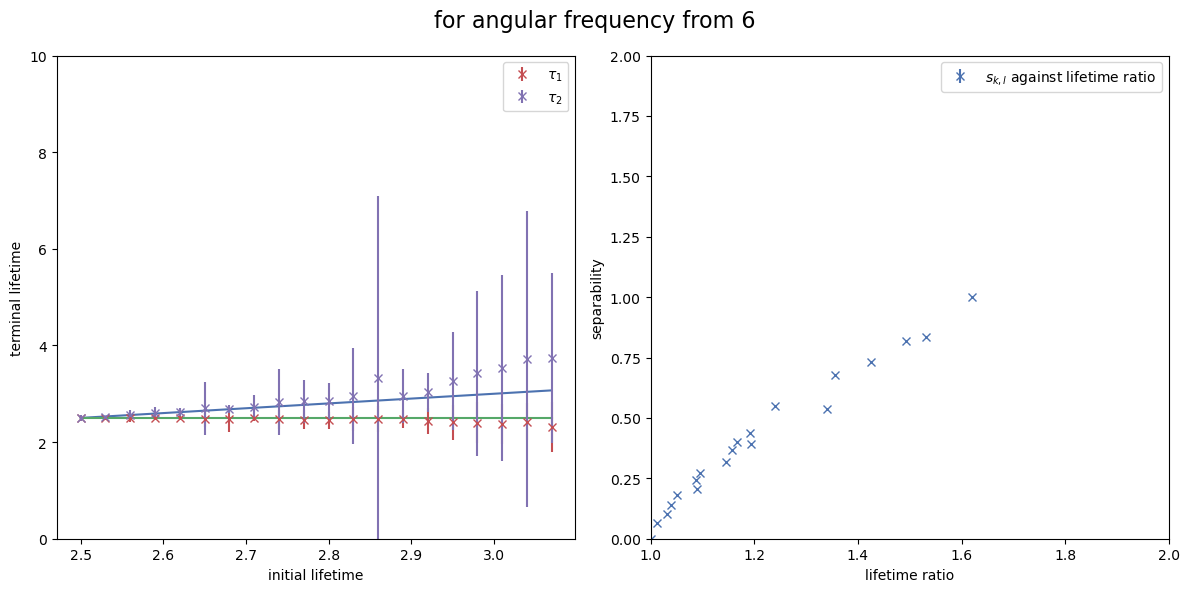

C:\Users\xujia\AppData\Local\Temp\ipykernel_2872\228629013.py:32: RuntimeWarning: invalid value encountered in divide
  separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5


separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


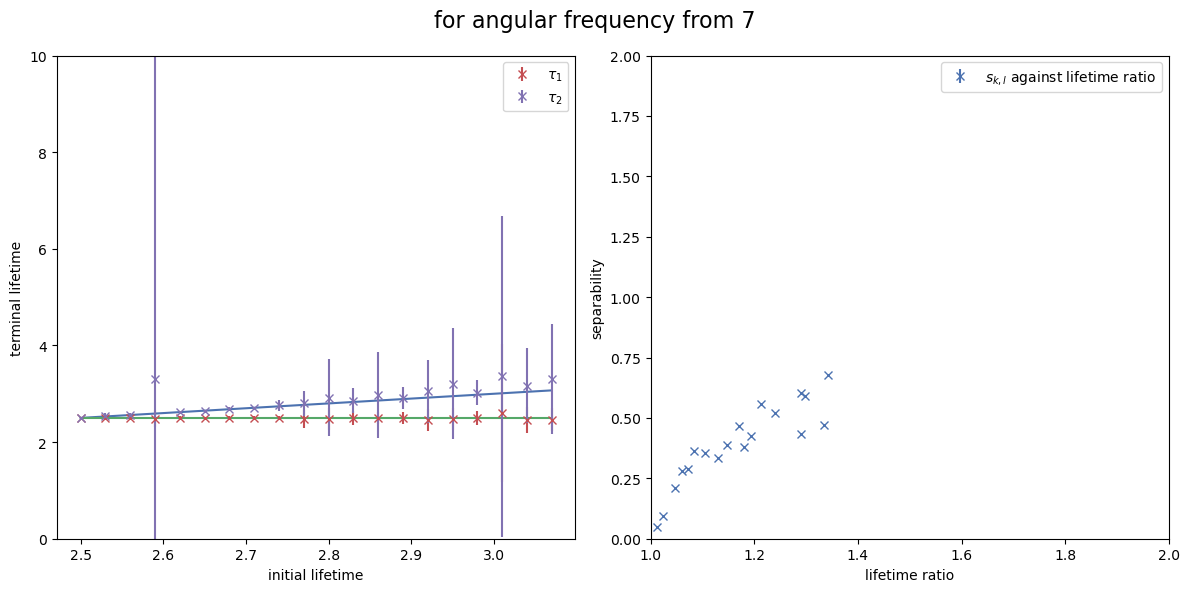

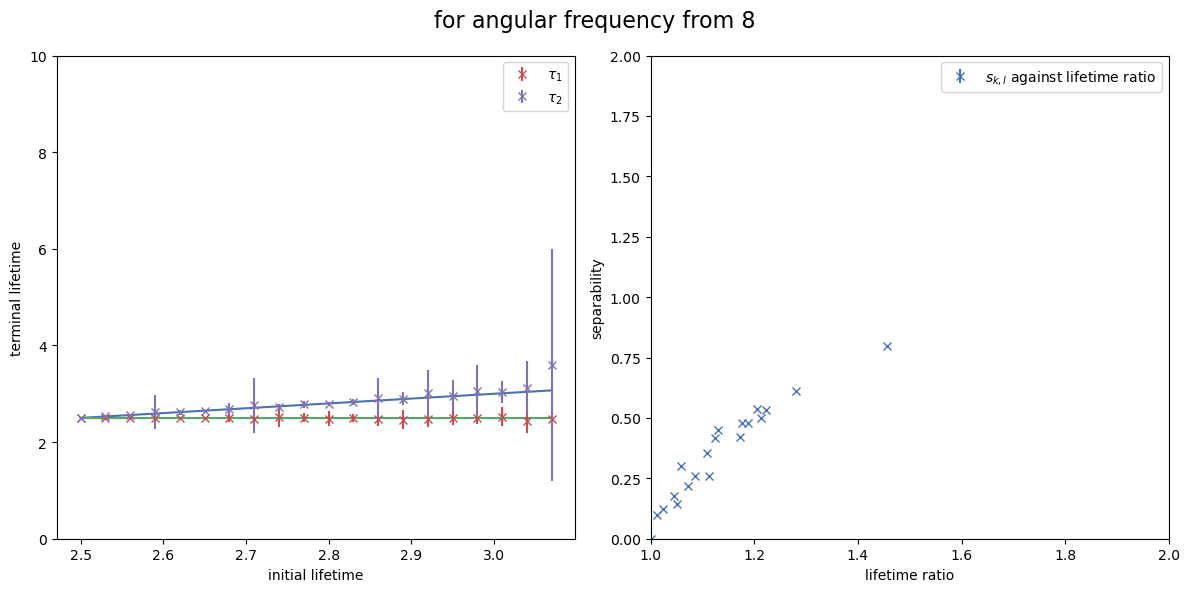

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


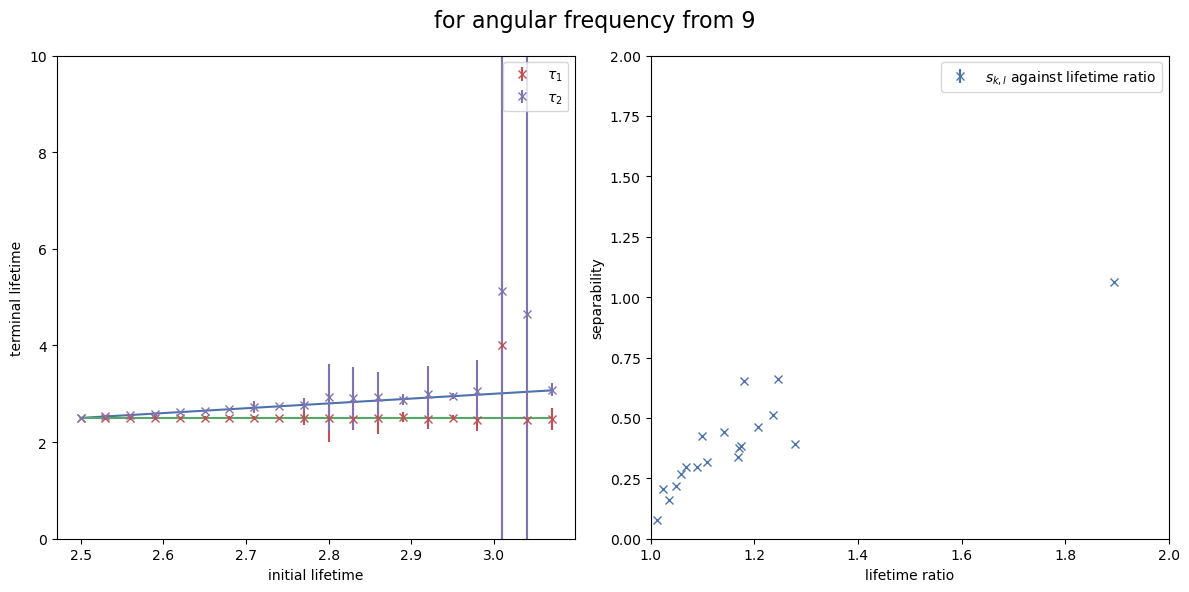

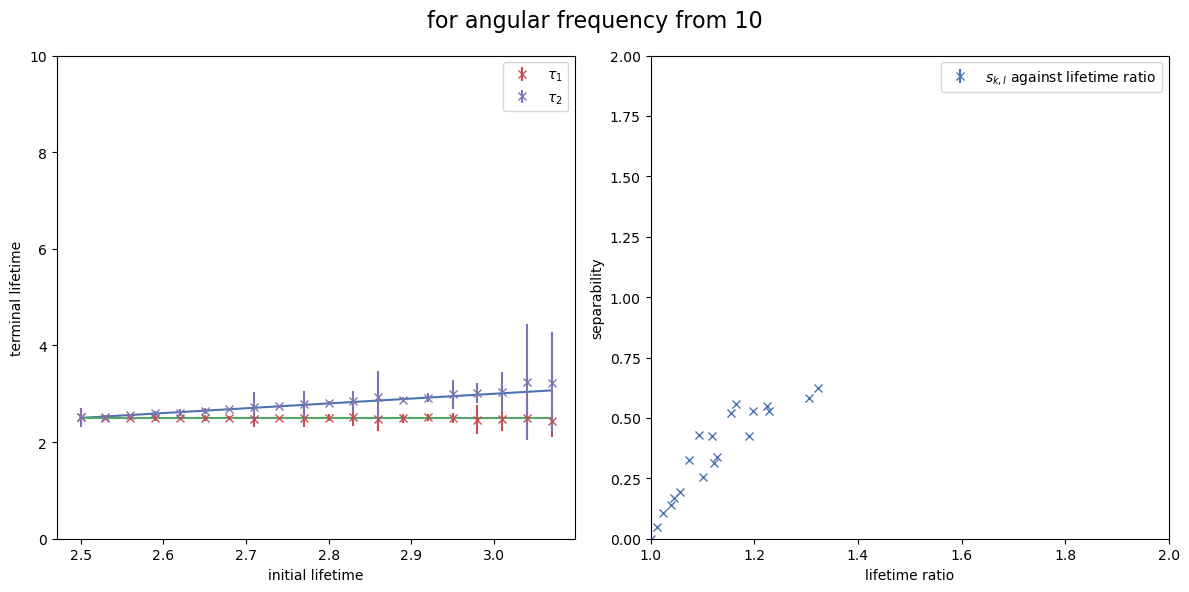

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


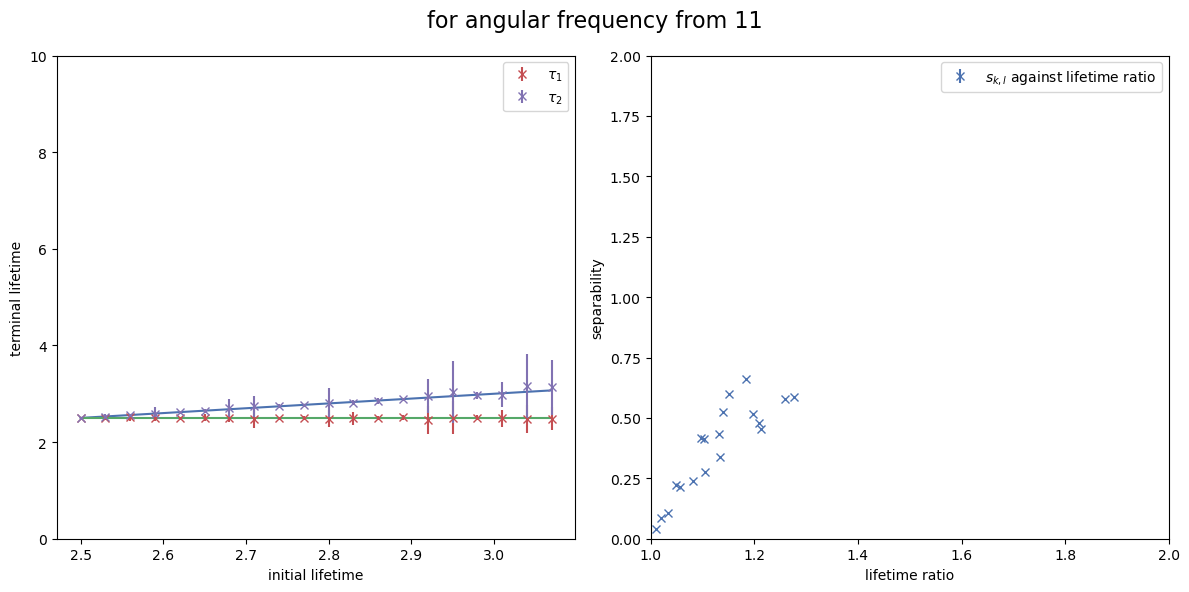

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


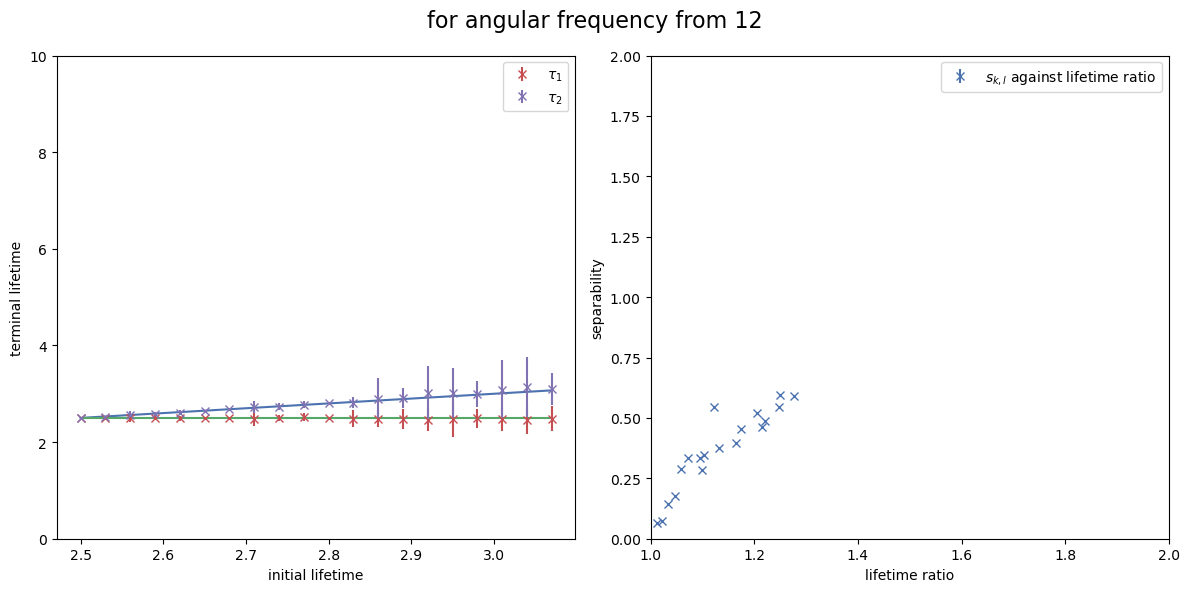

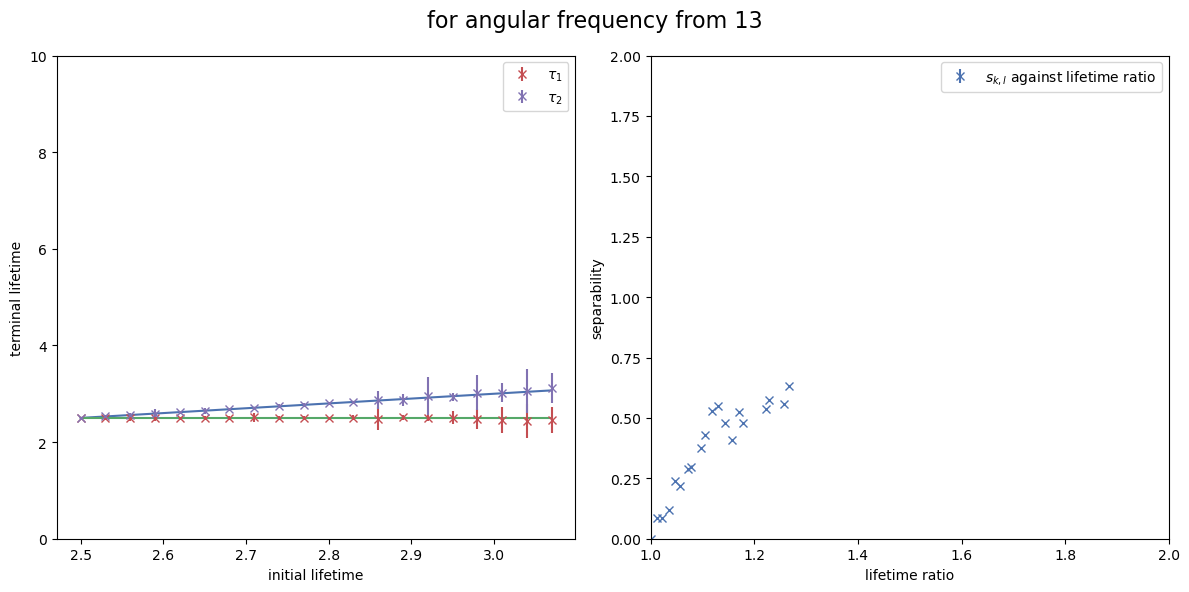

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


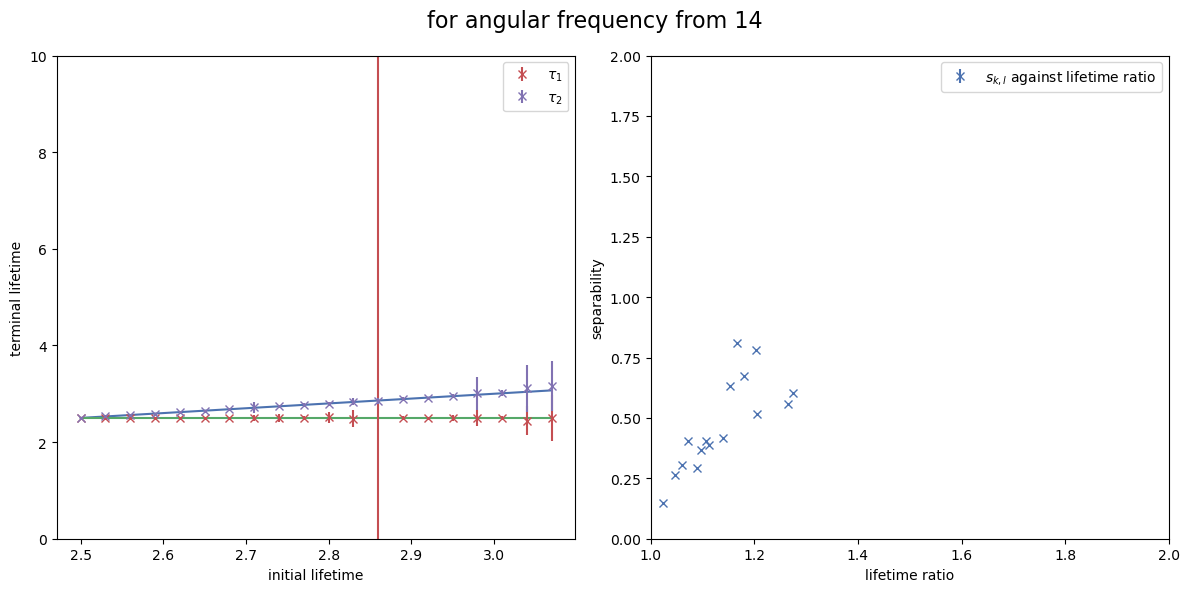

separability_kl is  173.7785625444099 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 2th data. 
Thus, the critical lifetime ratio is 1.0120000000000002


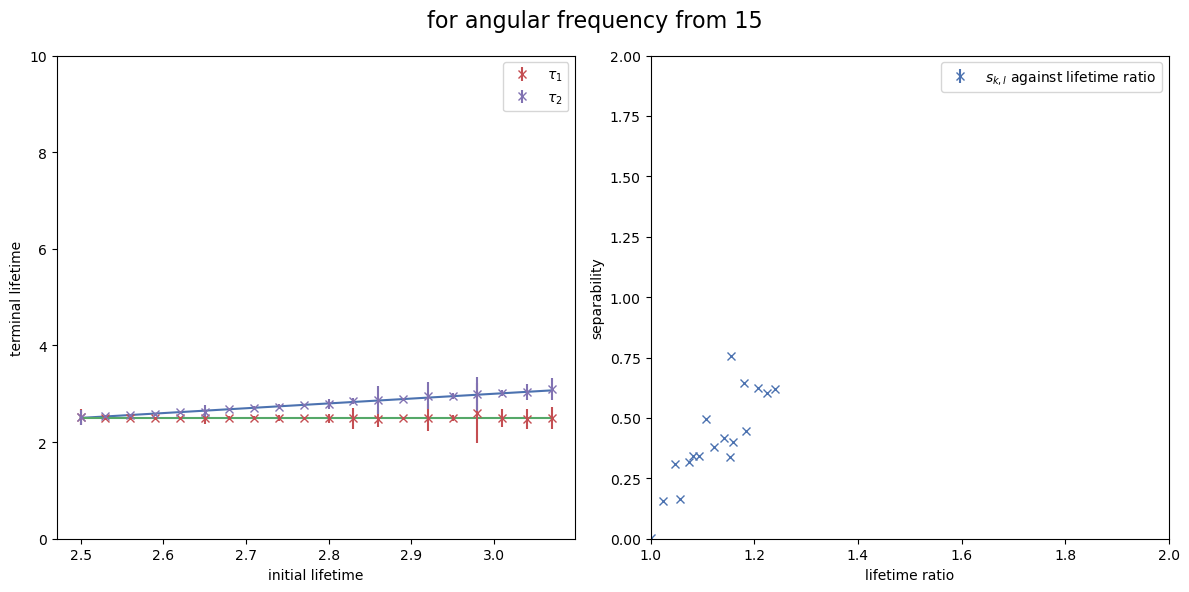

separability_kl is  414.60301223635014 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 4th data. 
Thus, the critical lifetime ratio is 1.036000000000001


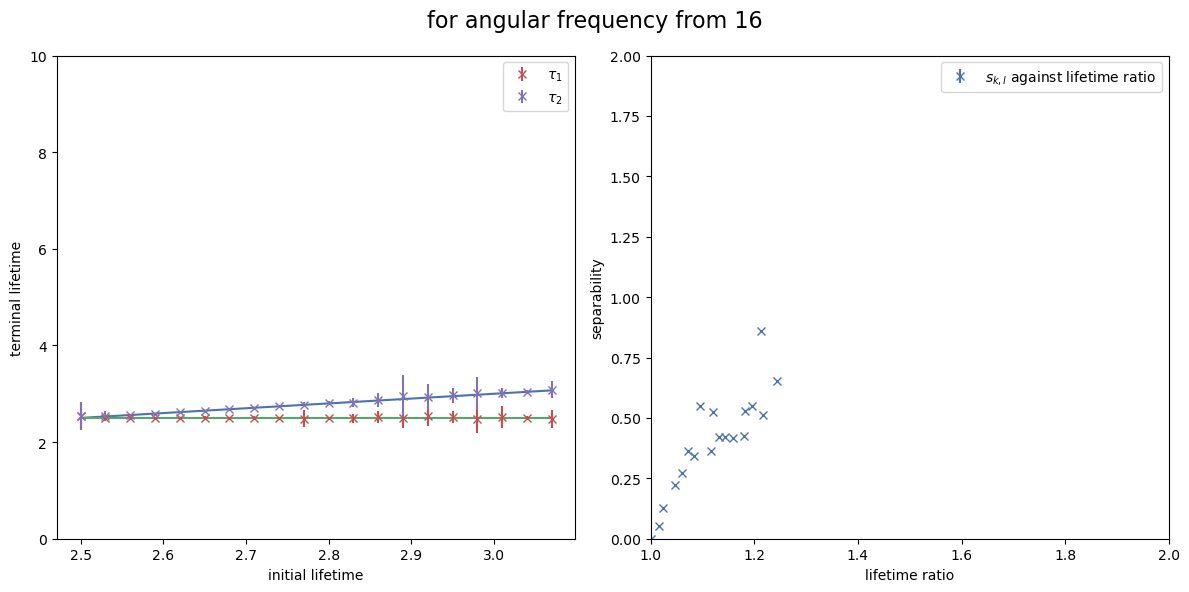

separability_kl is  1099.1866010969543 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 8th data. 
Thus, the critical lifetime ratio is 1.0840000000000005


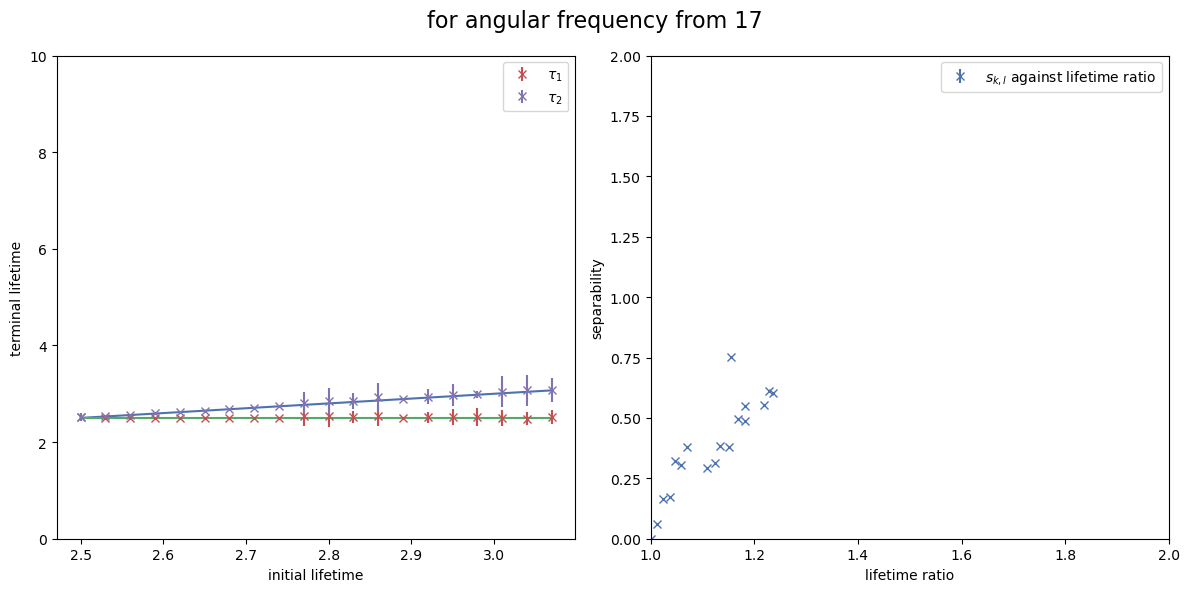

separability_kl is  173.7785625444099 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 2th data. 
Thus, the critical lifetime ratio is 1.0120000000000002


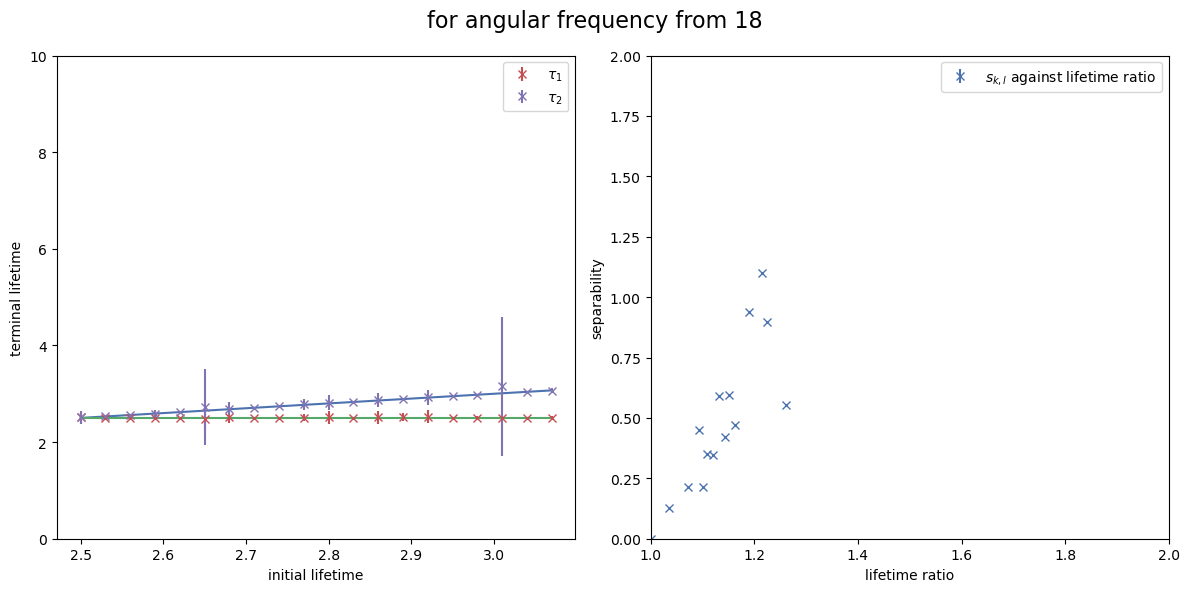

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


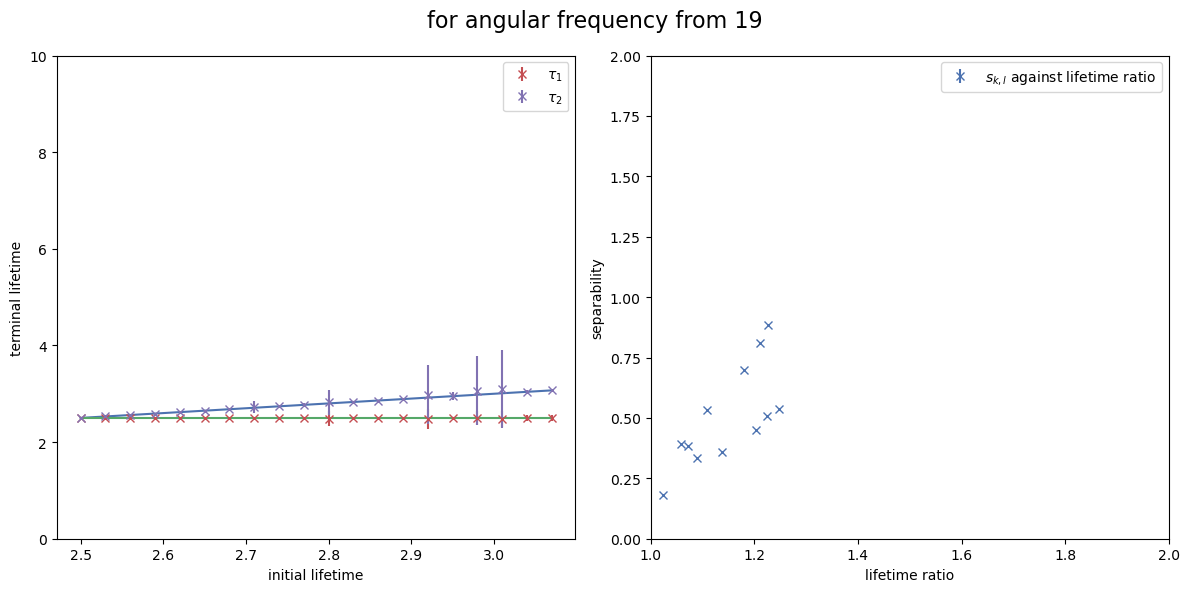

In [16]:
# simulation for different lifetimes
INDEX_array = range(20)
for INDEX_i in INDEX_array:
    tau_array = np.linspace(2.5,3.07,20)
    par_arr = np.zeros((20,100,3))
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.5,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau])
    
    INDEX_arr[INDEX_i], separation_arr[INDEX_i], critical_tau_arr[INDEX_i] = plot_w(par_arr)

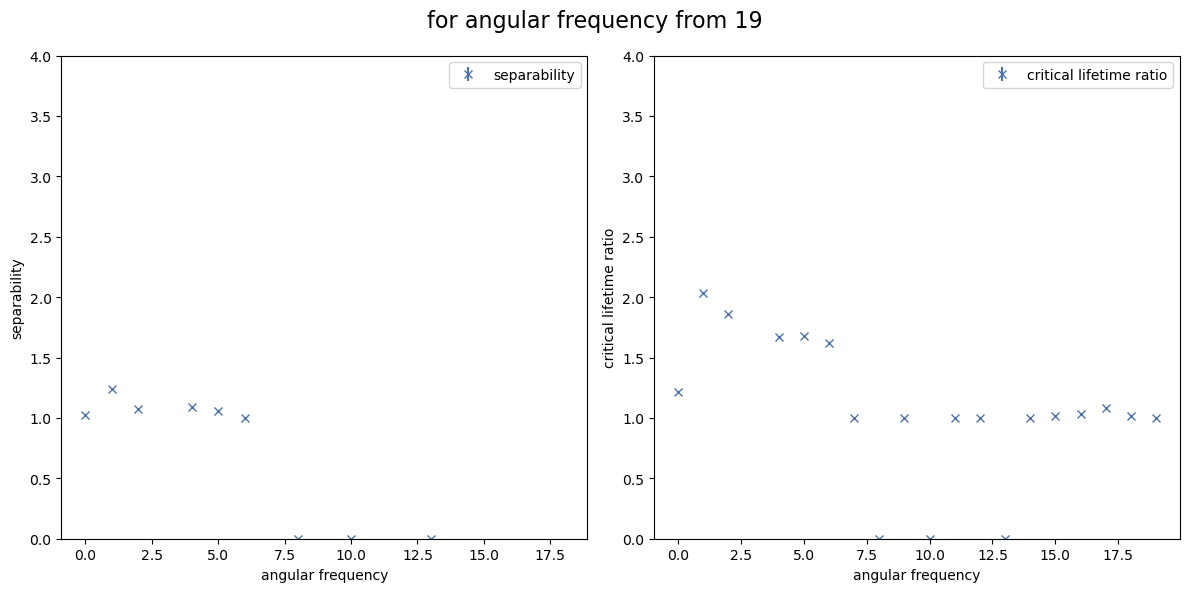

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"for angular frequency from {INDEX_i}", fontsize=16)
axs[0].set_ylim(0,4)
axs[1].set_ylim(0,4)

axs[0].errorbar(INDEX_arr, separation_arr, yerr=0, fmt='x', label="separability")
axs[0].set_xlabel("angular frequency")
axs[0].set_ylabel("separability")
axs[0].legend()
    
axs[1].errorbar(INDEX_arr, critical_tau_arr, yerr=0, fmt='x', label="critical lifetime ratio")
axs[1].set_xlabel("angular frequency")
axs[1].set_ylabel("critical lifetime ratio")
axs[1].legend()
    
plt.tight_layout()
plt.show()

The critical lifetime ratio would be  1.032647096117204  for varying angular frequency.


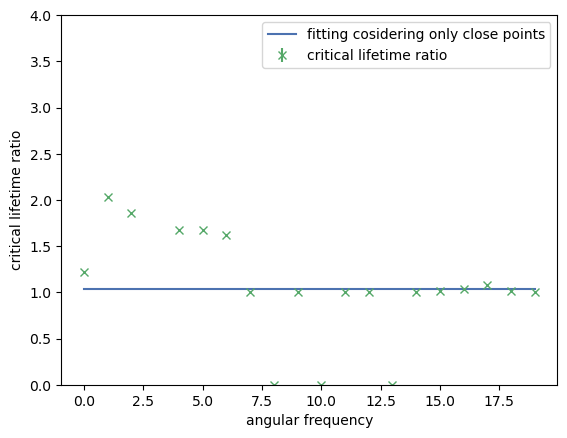

In [18]:
initial_guess = 1.05
selected = (critical_tau_arr > (initial_guess - 0.5)) & (critical_tau_arr < (initial_guess + 0.5))
fitted_critical_tau_arr = np.mean(critical_tau_arr[selected])
print("The critical lifetime ratio would be ",fitted_critical_tau_arr, " for varying angular frequency.")

plt.figure()
plt.ylim(0,4)
plt.plot([0,19],[fitted_critical_tau_arr,fitted_critical_tau_arr],label='fitting cosidering only close points')
plt.errorbar(INDEX_arr, critical_tau_arr, yerr=0, fmt='x', label="critical lifetime ratio")
plt.xlabel("angular frequency")
plt.ylabel("critical lifetime ratio")
plt.legend()
plt.show()

## Discuss behavior if using analytic phasor

In [31]:
# use analytic phasor: assign multi_exp_FT to phasor_test 
# multi_exp_FT(omega,A,tau,n) gives solve for A_tau_arr such that it gives 0

In [112]:
def multi_exp_FT(omega,A,tau):
    '''Analytic solution to Fourier Transform (normalized, i.e. divided by int_0^infty exp(-t/tau)dt) 
    of multi exponential decay with components lifetime tau
    Input:
    omega     angular frequency array
    A         amplitude array
    tau       lifetime'''
    coeff = A*tau/np.sum(A*tau) #coefficient of the sum of mono_exp_FT
    mono_arr = exp_FT(omega,tau)#array of FT of each lifetime
    return np.dot(coeff,mono_arr)

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n)]) #pure multiexponential
    # y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_test = multi_exp_FT(w,A_tau_arr[0:n],A_tau_arr[n:,]) 
    return phasor_test.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    
def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)

In [113]:
# simulation for different lifetimes
tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.5,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])

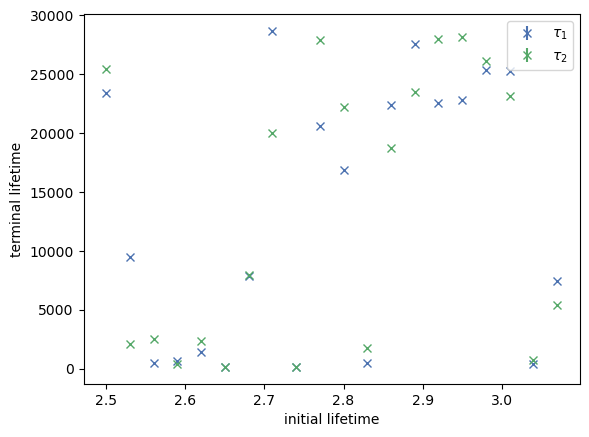

In [120]:
# calculate means and standard deviations
mean = np.mean(par_arr,axis = 1)
std = np.std(par_arr,axis = 1)

# plot 1D graph for simulated data
plt.figure()
# plt.axis("equal")
# plt.plot(tau_array,tau_array)
# plt.plot([2.5,3.07],[2.5,2.5])
plt.errorbar(tau_array,abs(mean[:,1]),yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,abs(mean[:,2]),yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.xlabel("initial lifetime")
plt.ylabel("terminal lifetime")
plt.legend()
plt.show()